In [1]:
import numpy as np
import pandas as pd
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

### I use an ARM-based Macbook, so I ran everything on the MPS backend. 

If you have an Nvidia GPU or an ARM-based Macbook (2020+), the code will run there. If not, CPU.

In [2]:
if torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")        

print(device)

mps


### Starting working with data

In [3]:
# Loading data into a pandas dataframe
data = pd.read_csv("dataset.csv")

data

,title,text,subject,date,Target,label
0,Connecticut cancels pay raises for managers as...,NEW YORK (Reuters) - Connecticut will cancel p...,politicsNews,"February 29, 2016",True,0
1,DELEGATES FOR DUMMIES: How They’re Awarded…And...,Stop counting the votes! Your candidates nomin...,left-news,"Mar 2, 2016",Fake,1
2,BITTER RADICAL ERIC HOLDER Goes After ‘ORANGE ...,The information below is disturbing and should...,left-news,"Nov 8, 2017",Fake,1
3,Clinton knocks Trump for cheering housing bubb...,WASHINGTON (Reuters) - Democrat Hillary Clinto...,politicsNews,"May 24, 2016",True,0
4,"British child sex-abuser, 102, sentenced for c...",LONDON (Reuters) - A 102-year-old man given a ...,worldnews,"September 11, 2017",True,0
...,...,...,...,...,...,...
44893,BOOM! FBI DIRECTOR CALLS HILLARY Out After She...,"It s not shocking that Hillary s lying again, ...",politics,"May 11, 2016",Fake,1
44894,"France's move to raise minimum food prices, li...","PARIS (Reuters) - France, the European Union s...",worldnews,"December 21, 2017",True,0
44895,New Obama Rule Will STOP Republicans From Def...,Republicans hate it. They really really hate i...,News,"September 9, 2016",Fake,1
44896,Bush hires Ohio political veteran as national ...,"CHARLESTON, S.C. (Reuters) - Republican Jeb Bu...",politicsNews,"February 18, 2016",True,0


## Train-test-split

In [4]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [14]:
# We'll be using the base BERT model from HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

### Prepare Input Data

In [15]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.", 
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [16]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

/Users/daniyarkakimbekov/anaconda3/envs/nlp/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
train_y = train_y.to(device)
train_mask = train_mask.to(device)
train_seq = train_seq.to(device)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
val_seq = val_seq.to(device)
val_mask = val_mask.to(device)
val_y = val_y.to(device)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
test_y = test_y.to(device)

In [18]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Define Model Architecture

In [19]:
for param in bert.parameters():
    param.requires_grad = False    

class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            
      self.relu =  nn.ReLU()                    
      self.fc1 = nn.Linear(768,512)             
      self.fc2 = nn.Linear(512,2)               
      self.softmax = nn.LogSoftmax(dim=1)       
    def forward(self, sent_id, mask):           
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
model.to(device)

from torch.optim import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          

cross_entropy  = nn.NLLLoss() 

epochs = 5

### Define Train & Evaluate Function

In [20]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

### Model training

In [21]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'fake_news.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.561
Validation Loss: 0.488

 Epoch 2 / 5
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

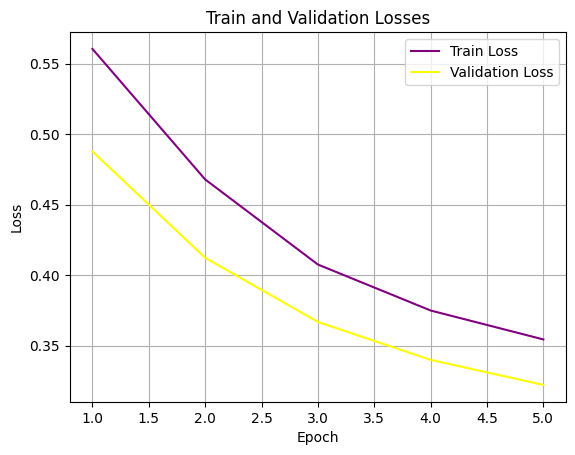

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, color='purple', label='Train Loss')
plt.plot(epochs, valid_losses, color='yellow', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend() 
plt.grid(True)  
# plt.savefig("losses.png",dpi=700)
plt.show()

## Some fast check for model performance:

#### everything seems to be fine

In [28]:
from sklearn.metrics import classification_report

with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)

# Since the predictions are on CPU, sending test_y to CPU so that we can plot the classification report
test_y = test_y.to("cpu")

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3212
           1       0.89      0.87      0.88      3523

    accuracy                           0.87      6735
   macro avg       0.87      0.87      0.87      6735
weighted avg       0.87      0.87      0.87      6735



## Checking how the model works on totally unseen data:

#### each unseen data was predicted correctly

In [48]:
unseen = [
            "Daniyar Kites has become the president of the US!",
            "Donald Trump has become the president of the US",
            "Joe Biden has become the president of the US",
            "Joe Biden wins voters' sympathies in Denver",
        ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_seq = unseen_seq.to(device)
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])
unseen_mask = unseen_mask.to(device)

with torch.no_grad():
  preds_unseen = model(unseen_seq, unseen_mask)
  preds_unseen = preds_unseen.detach().cpu().numpy()

preds_unseen = np.argmax(preds_unseen, axis = 1)

preds_unseen

array([1, 0, 0, 0])